# CLASSIFYING WIFI CSI SIGNAL USING A CNN CLASSIFIER

In [1]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

### Preprocessing:
* Make sure you download the npy files from https://deakin365.sharepoint.com/:f:/r/sites/GopherIndustries2/Shared%20Documents/Guardian%20Monitor/WiFi_CSI_Data/Room2_npy?csf=1&web=1&e=JVqAPk

The following code will:
* Upload the database from Room2_npy.
* Extract the real part of the complex numbers in the dataset.
* Normalise the data.
* Reshape the dataset to 7500 (samples) x 90 (subcarriers) for consistency in the input of the classifier.
* The database is imbalanced with kneel, liedown and pickup half size of the rest classes. For that reason, I balanced the data by making double size the classes mentioned before.
* Additionally, the dataset is small, with just 125 recording along all classes. So, I augmented the entire database 5 times.
* Encode the labels. 
* Save data and labels into numpy arrays.

In [2]:

dataset_path = 'Room2_npy'
target_length = 7500  
num_subcarriers = 90  

data_list = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup"]

for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                data = np.load(participant_path)

                data = np.real(data)
                
                min_val = np.min(data)
                max_val = np.max(data)
                data_normalized = (data - min_val) / (max_val - min_val) if max_val != min_val else data
                
                if data_normalized.shape[0] > target_length:
                    data_normalized = data_normalized[:target_length]
                
                data_list.append(data_normalized)
                
                label = activity_folder
                if label in classes_to_double:
                    data_list.append(data_normalized)  
                    labels_list.append(label)  
                
                labels_list.append(label)  


data_list *= 5
labels_list *= 5

data = np.array(data_list)
labels = np.array(labels_list)

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

### Splitting the dataset

* Training: 70%  
* Validation: 20%   
* Test: 10% 

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.219,  random_state = 42)

### Building a CNN classifier

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [5]:
model = Sequential([
    Input(shape=(7500, 90)),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), 
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l1(0.01)), 
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
    Dropout(0.4),
    Dense(8, activation='softmax')])

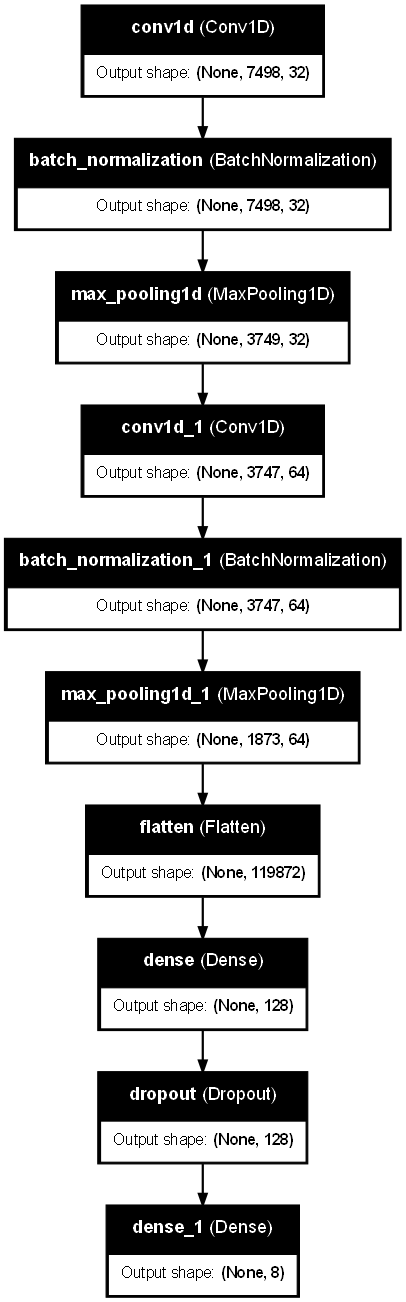

In [6]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=80)

### Training the model

In [7]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=4,
                    validation_data=(X_val, y_val))

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.3092 - loss: 1169.7080 - val_accuracy: 0.2353 - val_loss: 299.7816
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.3621 - loss: 296.1416 - val_accuracy: 0.2092 - val_loss: 267.5188
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.3720 - loss: 257.3423 - val_accuracy: 0.2092 - val_loss: 231.5481
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.3615 - loss: 227.8157 - val_accuracy: 0.2876 - val_loss: 210.8427
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - accuracy: 0.3939 - loss: 203.5424 - val_accuracy: 0.1111 - val_loss: 202.0811
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - accuracy: 0.3428 - loss: 195.3791 - val_accuracy: 0.1503 - val_loss: 197.6973
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.3920 - loss: 189.7567 - val_accuracy: 0.2222 - val_loss: 183.8117
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step

### Evaluating the model

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def performance_plot(history, model, test_images, test_labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

    # Plot Accuracy
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Plot Loss
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    # Generating predictions and plot Confusion Matrix
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(true_classes, predicted_classes)

    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    print(f'Test loss: {test_loss*100:.2f}')
    print(f'Test accuracy: {test_acc*100:.2f}%')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['kneel', 'liedown', 'pickup', 'sit', 'sitrotate', 'stand', 'standrotate', 'walk'])
    disp.plot(include_values=True, cmap='viridis', ax=axs[2], xticks_rotation='vertical', colorbar=False)
    axs[2].set_title("Confusion Matrix")
    
    plt.tight_layout()
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 - 0s - 128ms/step - accuracy: 0.7564 - loss: 178.4569
Test loss: 17845.69
Test accuracy: 75.64%


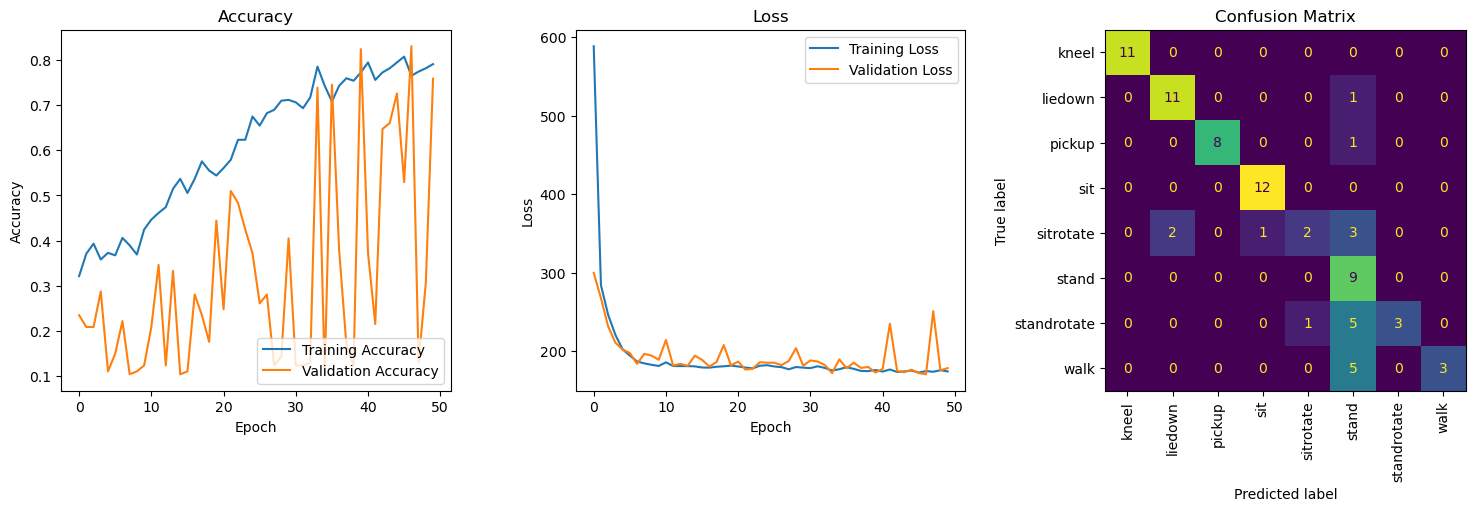

In [10]:
performance_plot(history, model, X_test, y_test)